In [1]:
from scipy.integrate import odeint 
import time
import math
import numpy as np
from math import *
import pickle as pkl
import tensorflow as tf
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout, Input
from keras.optimizers import Adam, AdamW
from keras.callbacks import EarlyStopping
import numpy as np
from scipy.optimize import newton
from matplotlib import animation, rc
from matplotlib import pyplot as plt

2024-11-06 18:59:27.209568: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 18:59:27.220537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 18:59:27.233646: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 18:59:27.237233: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 18:59:27.246320: I tensorflow/core/platform/cpu_feature_guar

In [2]:
m1 = 2                 # mass of pendulum 1 (in kg)
m2 = 1                # mass of pendulum 2 (in kg)
L1 = 1.4                 # length of pendulum 1 (in meter)
L2 = 1               # length of pendulum 2 (in meter)
g = 9.8                # gravitatioanl acceleration constant (m/s^2)

In [3]:
u0 = [-np.pi/10.2, 0, np.pi/5.8, 0]    # initial conditions. 
tfinal = 25.0       # Final time. Simulation time = 0 to tfinal.
Nt = 751
t = np.linspace(0, tfinal, Nt)

In [4]:
# Differential equations describing the system
def double_pendulum(u,t,m1,m2,L1,L2,g):
    # du = derivatives
    # u = variables
    # p = parameters
    # t = time variable
    
    du = np.zeros(4)
    c = np.cos(u[0]-u[2])  # intermediate variables
    s = np.sin(u[0]-u[2])  # intermediate variables

    du[0] = u[1]   # d(theta 1)
    du[1] = ( m2*g*np.sin(u[2])*c - m2*s*(L1*c*u[1]**2 + L2*u[3]**2) - (m1+m2)*g*np.sin(u[0]) ) /( L1 *(m1+m2*s**2) )
    du[2] = u[3]   # d(theta 2)   
    du[3] = ((m1+m2)*(L1*u[1]**2*s - g*np.sin(u[2]) + g*np.sin(u[0])*c) + m2*L2*u[3]**2*s*c) / (L2 * (m1 + m2*s**2))
    
    return du

def makepath(theta1, theta2,t_final, d_t):
    u0 = [np.pi*theta1/180, 0, np.pi*theta2/180, 0]
    t = np.arange(0, t_final+d_t, d_t)
    sol = odeint(double_pendulum, u0, t, args=(m1,m2,L1,L2,g))
    return sol

In [5]:
train_window = 40

def create_inout_sequences_batches(input_data, tw):
    inout_seq = []
    batches,L,dim = (input_data).shape
    for i in range(batches):
        for j in range(L-tw):
            train_seq = input_data[i,j:j+tw,:]
            train_label = input_data[i,j+tw:j+tw+1,:]
            inout_seq.append((train_seq ,train_label))
    return inout_seq

In [6]:
theta1s = np.arange(-45,45,2)
theta2s = np.arange(-35,35,5)

In [7]:
theta1s = np.arange(-45,45,5)
theta2s = np.arange(-35,35,5)

solucoes = []
for theta1 in theta1s:
    for theta2 in theta2s:
        solucao = makepath(theta1,theta2,5.0,0.01)
        solucoes.append(solucao)

solucoes_val =[]

for i in range(5):
    solucao = makepath(np.random.uniform(-50,50),np.random.uniform(-40,40),5.0,0.01)
    solucoes_val.append(solucao)

In [8]:
solucoes = np.array(solucoes)
solucoes_val = np.array(solucoes_val)

#Z scale
media = np.mean(solucoes,axis=(0,1))
std = np.std(solucoes,axis=(0,1))

print(media,std)

solucoes = (solucoes-media)/std
solucoes_val = (solucoes_val-media)/std
print(solucoes.shape)

[0.00294017 0.00837015 0.00748884 0.00731816] [0.24583239 0.70262596 0.51331663 1.62254147]
(252, 501, 4)


In [9]:
sequencias = create_inout_sequences_batches(solucoes,train_window) 
inputs = tf.convert_to_tensor([sequencias[i][0] for i in range(len(sequencias))],dtype=tf.float32)
outputs = tf.reshape(tf.convert_to_tensor([sequencias[i][1] for i in range(len(sequencias))],dtype=tf.float32),(-1,4))

sequencias_val = create_inout_sequences_batches(solucoes_val,train_window) 
inputs_val = tf.convert_to_tensor([sequencias_val[i][0] for i in range(len(sequencias_val))],dtype=tf.float32)
outputs_val = tf.reshape(tf.convert_to_tensor([sequencias_val[i][1] for i in range(len(sequencias_val))],dtype=tf.float32),(-1,4))




I0000 00:00:1730930379.723585   44814 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730930379.750561   44814 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730930379.752097   44814 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730930379.753932   44814 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [13]:
inputs.shape

TensorShape([116172, 40, 4])

In [10]:
model_keras = Sequential([
    Input((train_window,4)),
    LSTM(512, return_sequences=True),
    LSTM(256, return_sequences=True),
    LSTM(128,return_sequences=False),
    Dense(4,activation="linear")])
model_keras.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40, 512)        │     1,058,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 40, 256)        │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,043,908 (7.80 MB)

 Trainable params: 2,043,908 (7.80 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model_keras.load_weights("modelos_de_verdade/pesos_LSTM_PD_geral_45_35_seq_40.weights.h5")

In [237]:
def scaled_mse(x,y):
    return 100*tf.reduce_mean(tf.square(x-y))

earlystop = EarlyStopping(monitor="val_loss",patience=50,restore_best_weights=1)

model_keras.compile(optimizer=Adam(learning_rate=1e-6,amsgrad=1),loss="mse",metrics=["mae"])
model_keras.fit(inputs,outputs,validation_data=(inputs_val,outputs_val),epochs=400,batch_size=256*4, verbose = 2,callbacks=earlystop,shuffle=1)
print("Acabou o treinamento!")

Epoch 1/400
335/335 - 13s - 38ms/step - loss: 2.7876e-07 - mae: 3.4097e-04 - val_loss: 5.5398e-07 - val_mae: 5.0344e-04
Epoch 2/400
335/335 - 11s - 34ms/step - loss: 2.7981e-07 - mae: 3.4200e-04 - val_loss: 5.2949e-07 - val_mae: 5.0216e-04
Epoch 3/400
335/335 - 11s - 34ms/step - loss: 2.7925e-07 - mae: 3.4170e-04 - val_loss: 5.3332e-07 - val_mae: 5.0749e-04
Epoch 4/400
335/335 - 11s - 34ms/step - loss: 2.7803e-07 - mae: 3.4092e-04 - val_loss: 5.4369e-07 - val_mae: 5.0828e-04
Epoch 5/400
335/335 - 11s - 34ms/step - loss: 2.7663e-07 - mae: 3.3996e-04 - val_loss: 5.3496e-07 - val_mae: 4.9823e-04
Epoch 6/400
335/335 - 11s - 33ms/step - loss: 2.7472e-07 - mae: 3.3870e-04 - val_loss: 5.3792e-07 - val_mae: 5.0339e-04
Epoch 7/400
335/335 - 11s - 34ms/step - loss: 2.7524e-07 - mae: 3.3922e-04 - val_loss: 5.4577e-07 - val_mae: 5.1288e-04
Epoch 8/400
335/335 - 11s - 33ms/step - loss: 2.7195e-07 - mae: 3.3700e-04 - val_loss: 5.0908e-07 - val_mae: 4.8458e-04
Epoch 9/400
335/335 - 11s - 33ms/step - 

KeyboardInterrupt: 

In [197]:
model_keras.save_weights("pesos_LSTM_PD_geral_45_35_seq_40.weights.h5")

(551, 4) (551, 4)
MSE: 0.12149347578273305
MAE: 0.1735200040473757


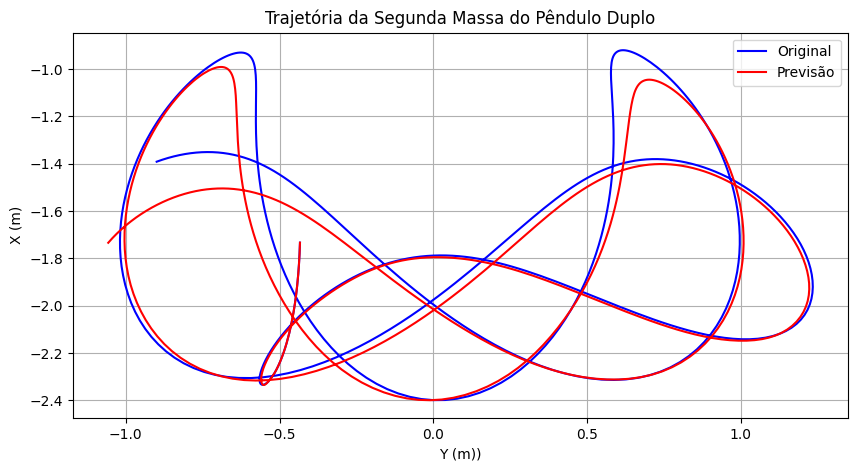

In [27]:
extrapol = True
ruido = False
t_final = 5 + 0.5*extrapol
sol2 = makepath(-47.93,37.29 ,t_final,0.01)
previsoes = ((sol2[:train_window,:]+ruido*np.random.normal(0,0.005 * np.ptp(sol2,axis=0),size=(train_window,4))-media)/std).tolist()
for i in range(int(t_final*100-train_window+1)):
    prev_temp = model_keras((np.array([previsoes[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,4)),training=False)
    previsoes.append(prev_temp.numpy().tolist()[0])
previsoes = np.array(previsoes)*std+media


plt.figure(figsize=(10,5))
x = sol2[:,0]
v =  sol2[:,1]
x_2 = previsoes[:,0]
v_2= previsoes[:,1]

u0 = sol2[:,0]     # theta_1 
u1 = sol2[:,1]     # omega 1
u2 = sol2[:,2]     # theta_2 
u3 = sol2[:,3]     # omega_2 
x1 = L1*np.sin(u0);          # First Pendulum
y1 = -L1*np.cos(u0);
x2 = x1 + L2*np.sin(u2);     # Second Pendulum
y2 = y1 - L2*np.cos(u2);

u0_2 = previsoes[:,0]     # theta_1 
u1_2 = previsoes[:,1]     # omega 1
u2_2 = previsoes[:,2]     # theta_2 
u3_2 = previsoes[:,3]     # omega_2 
x1_2 = L1*np.sin(u0_2);          # First Pendulum
y1_2 = -L1*np.cos(u0_2);
x2_2 = x1_2 + L2*np.sin(u2_2);     # Second Pendulum
y2_2 = y1_2 - L2*np.cos(u2_2);

n,m = 0,-1
print(previsoes.shape, sol2.shape)
plt.plot(x2[n:m], y2[n:m], 'b-', label="Original")
plt.plot(x2_2[n:m], y2_2[n:m], 'r-',label="Previsão",markersize=1.6)
print(f"MSE: {(tf.reduce_mean(tf.square(previsoes[train_window:]-sol2[train_window:])))}")
print(f"MAE: {(tf.reduce_mean(tf.abs(previsoes[train_window:]-sol2[train_window:])))}")
plt.xlabel("Y (m))")
plt.ylabel("X (m)")
plt.title("Trajetória da Segunda Massa do Pêndulo Duplo")
plt.grid(1)
plt.legend()

In [48]:
def teste(angulos1, angulos2, extrapol, ruido):
    mse = 0
    mae = 0
    mae2 = 0
    cont = 0    

    mae_min = 999
    mae_max = 0
    combinacao_min = 0
    combinacao_max = 0

    for angle1 in angulos1:
        for angle2 in angulos2:
            t_final = 5 + 0.5*extrapol
            sol2 = makepath(angle1,angle2,t_final,0.01)
            previsoes = ((sol2[:train_window,:]+ruido*np.random.normal(0,0.005 * np.ptp(sol2,axis=0),size=(train_window,4))-media)/std).tolist()
            for i in range(int(t_final*100-train_window+1)):
                prev_temp = model_keras((np.array([previsoes[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,4)),training=False)
                previsoes.append(prev_temp.numpy().tolist()[0])
            previsoes = np.array(previsoes)*std+media
            mse_temp0=(tf.reduce_mean(tf.square(previsoes[train_window+extrapol*(501-train_window):]-sol2[train_window+extrapol*(501-train_window):]),axis=0))
            mae_temp0=(tf.reduce_mean(tf.abs(previsoes[train_window+extrapol*(501-train_window):]-sol2[train_window+extrapol*(501-train_window):]),axis=0))
            mae_temp1=(tf.reduce_mean(tf.abs(previsoes[train_window+extrapol*(501-train_window):]-sol2[train_window+extrapol*(501-train_window):])))
            mse+=mse_temp0
            mae+=mae_temp0
            mae2+=mae_temp1
            cont+=1

    
    #tf.print(f"MSE {mse/cont}")
    mae = np.append(mae,mae2)
    with np.printoptions(precision=3):
        tf.print(f"MAE {mae/cont}")
            
    #print(combinacao_max, mae_max)
    #print(combinacao_min,mae_min)
    print()
    

In [21]:
np.linspace(-45,45,18)

array([-45.        , -39.70588235, -34.41176471, -29.11764706,
       -23.82352941, -18.52941176, -13.23529412,  -7.94117647,
        -2.64705882,   2.64705882,   7.94117647,  13.23529412,
        18.52941176,  23.82352941,  29.11764706,  34.41176471,
        39.70588235,  45.        ])

In [50]:
angulos1_1 = np.linspace(-45,45,18)
angulos1_2 = np.append(np.linspace(-50,-45.5,5),np.linspace(45.5,50.5,5))
angulos2_1 = np.linspace(-35,35,18)
angulos2_2 = np.append(np.linspace(-40,-35.5,5),np.linspace(35.5,40,5))


lista_angulos1 = [angulos1_1,angulos1_2]
lista_angulos2 = [angulos2_1,angulos2_2]

print("Sem Nada")
print()
cont_angulo1 = 1
cont_angulo2 = 1
for theta1_teste in lista_angulos1:
    cont_angulo1 = 1
    for theta2_teste in lista_angulos2:
        print(f"A1 {cont_angulo1} A2 {cont_angulo2}")
        teste(theta1_teste,theta2_teste,extrapol=False,ruido=False)
        cont_angulo1 +=1
    cont_angulo2+=1
print("Extrapolação")
print()
cont_angulo1 = 1
cont_angulo2 = 1
for theta1_teste in lista_angulos1:
    cont_angulo1 = 1
    for theta2_teste in lista_angulos2:
        print(f"A1 {cont_angulo1} A2 {cont_angulo2}")
        teste(theta1_teste,theta2_teste,extrapol=True,ruido=False)
        cont_angulo1 +=1
    cont_angulo2+=1
print("Ruído")
print()

cont_angulo1 = 1
cont_angulo2 = 1
for theta1_teste in lista_angulos1:
    cont_angulo2 = 1
    for theta2_teste in lista_angulos2:
        print(f"A1 {cont_angulo1} A2 {cont_angulo2}")
        teste(theta1_teste,theta2_teste,extrapol=False,ruido=True)
        cont_angulo2 +=1
    cont_angulo1+=1


Sem Nada

A1 1 A2 1
MAE [0.001 0.005 0.004 0.013 0.006]

A1 2 A2 1
MAE [0.003 0.01  0.007 0.023 0.011]

A1 1 A2 2
MAE [0.014 0.053 0.047 0.141 0.064]

A1 2 A2 2
MAE [0.029 0.099 0.086 0.225 0.11 ]

Extrapolação

A1 1 A2 1
MAE [0.003 0.011 0.008 0.033 0.014]

A1 2 A2 1
MAE [0.008 0.021 0.017 0.075 0.03 ]

A1 1 A2 2
MAE [0.044 0.125 0.087 0.463 0.18 ]

A1 2 A2 2
MAE [0.077 0.247 0.143 1.003 0.368]

Ruído

A1 1 A2 1
MAE [0.002 0.006 0.004 0.015 0.007]

A1 2 A2 1
MAE [0.003 0.011 0.008 0.025 0.011]

A1 1 A2 2
MAE [0.014 0.055 0.048 0.145 0.066]

A1 2 A2 2
MAE [0.029 0.1   0.087 0.228 0.111]

